In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import scipy.optimize as sco
import re

抓股票代號

In [2]:
#抓美國市值前一百的股票代號
US100_stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://tw.tradingview.com/markets/stocks-usa/market-movers-large-cap/", headers=headers)

soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat"][target="_blank"]')

for tag in stock_tags:
    US100_stocks.append(tag.text)

利用前面抓的股票代號來抓歷史股價

In [3]:
#用yfinance抓美股股價
import yfinance as yf

random.seed(42) #固定種子複現結果
US10_Stocks = random.sample(US100_stocks, 10)

US10_stocks_prices = {}
for stock in US10_Stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(period="2y")
    US10_stocks_prices[stock] = historical_data

In [4]:
US10_Stocks

['SCHW', 'JNJ', 'AMZN', 'ETN', 'CMCSA', 'TMO', 'BAC', 'AVGO', 'JPM', 'UBER']

利用股價生成日報酬

In [5]:
#將股價換算成日報酬率的函數
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [6]:
US10_stocks_returns = get_stocks_returns(US10_stocks_prices)

In [7]:
pd.DataFrame(US10_stocks_returns)

,SCHW,JNJ,AMZN,ETN,CMCSA,TMO,BAC,AVGO,JPM,UBER
0,0.021691,-0.006378,-0.000542,0.008974,0.022886,0.002433,0.014841,0.004990,0.021016,0.050223
1,-0.015990,-0.007790,-0.028472,-0.015201,-0.007516,-0.006495,0.006035,-0.023392,-0.001077,-0.028268
2,0.036460,0.002261,0.009788,0.019547,0.004599,0.005062,0.020305,0.019897,0.016330,-0.002406
3,-0.002503,0.002068,0.012732,0.002909,0.001937,0.006505,0.000452,0.006922,0.002135,0.030695
4,0.008982,0.008943,0.012391,0.014635,0.008787,0.013742,-0.002713,0.010516,0.006330,0.019145
...,...,...,...,...,...,...,...,...,...,...
497,0.003626,-0.001495,0.016651,0.015236,-0.009492,0.005708,-0.001447,0.005802,0.004941,0.011259
498,-0.020777,-0.007737,-0.040299,-0.022371,-0.014041,-0.008049,-0.015580,-0.021226,-0.010379,-0.014251
499,0.003321,-0.012011,0.000000,0.015587,0.008137,-0.006579,0.003681,0.000760,0.005865,0.019652
500,0.003126,-0.001464,0.000000,0.005458,0.005830,0.009492,0.010634,0.018597,0.012416,0.022153


計算統計數字

In [8]:
#計算平均報酬
US10_stocks_expected_return = {}
for stock in US10_stocks_returns:
    US10_stocks_expected_return[stock] = (US10_stocks_prices[stock]['Close'][len(US10_stocks_prices[stock])-1] - US10_stocks_prices[stock]['Close'][0]) / US10_stocks_prices[stock]['Close'][0]

mean_returns = pd.Series(US10_stocks_expected_return)
mean_returns

SCHW    -0.226783
JNJ      0.018293
AMZN    -0.226067
ETN      0.486969
CMCSA   -0.164097
TMO     -0.109959
BAC     -0.321576
AVGO     0.811342
JPM     -0.060116
UBER     0.026563
dtype: float64

In [9]:
#共變異數矩陣
cov_matrix = pd.DataFrame(US10_stocks_returns).cov()
cov_matrix

,SCHW,JNJ,AMZN,ETN,CMCSA,TMO,BAC,AVGO,JPM,UBER
SCHW,0.000589,0.000041,0.000180,0.000185,0.000111,0.000118,0.000279,0.000174,0.000199,0.000279
JNJ,0.000041,0.000116,0.000042,0.000044,0.000051,0.000051,0.000046,0.000036,0.000048,0.000015
AMZN,0.000180,0.000042,0.000706,0.000174,0.000174,0.000202,0.000209,0.000316,0.000169,0.000482
ETN,0.000185,0.000044,0.000174,0.000290,0.000109,0.000140,0.000165,0.000202,0.000159,0.000199
CMCSA,0.000111,0.000051,0.000174,0.000109,0.000296,0.000087,0.000136,0.000150,0.000118,0.000202
TMO,0.000118,0.000051,0.000202,0.000140,0.000087,0.000297,0.000128,0.000178,0.000114,0.000190
BAC,0.000279,0.000046,0.000209,0.000165,0.000136,0.000128,0.000337,0.000169,0.000257,0.000237
AVGO,0.000174,0.000036,0.000316,0.000202,0.000150,0.000178,0.000169,0.000468,0.000159,0.000304
JPM,0.000199,0.000048,0.000169,0.000159,0.000118,0.000114,0.000257,0.000159,0.000270,0.000210
UBER,0.000279,0.000015,0.000482,0.000199,0.000202,0.000190,0.000237,0.000304,0.000210,0.001150


In [58]:
# 建立報酬率及標準差函數
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) 
    return std, returns

# 建立隨機投資組合
# 自訂投資組合數
num_portfolios = 100000

def random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((10,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(US10_Stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return) / portfolio_std_dev
    return results, weights_record

In [59]:
# SAMPLE：隨機投資組合

results = np.zeros((10,num_portfolios))
weights_record = []
for i in range(num_portfolios):
    weights = np.random.random(len(US10_Stocks))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
    results[0,i] = portfolio_std_dev
    results[1,i] = portfolio_return
    results[2,i] = (portfolio_return) / portfolio_std_dev

print('-' * 100)
print('平均報酬：\n',mean_returns )
print('-' * 100)
print('投組權重：', weights_record[0])
print('-' * 100)
print('報酬率：', results[1][0])
print('-' * 100)
print('標準差：', results[0][0])
print('-' * 100)

----------------------------------------------------------------------------------------------------
平均報酬：
 SCHW    -0.226783
JNJ      0.018293
AMZN    -0.226067
ETN      0.486969
CMCSA   -0.164097
TMO     -0.109959
BAC     -0.321576
AVGO     0.811342
JPM     -0.060116
UBER     0.026563
dtype: float64
----------------------------------------------------------------------------------------------------
投組權重： [0.11508621 0.13370531 0.11738817 0.17130213 0.04399543 0.04790765
 0.15157186 0.01819637 0.13893423 0.06191264]
----------------------------------------------------------------------------------------------------
報酬率： -0.019945925936997358
----------------------------------------------------------------------------------------------------
標準差： 0.013461825748497953
----------------------------------------------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


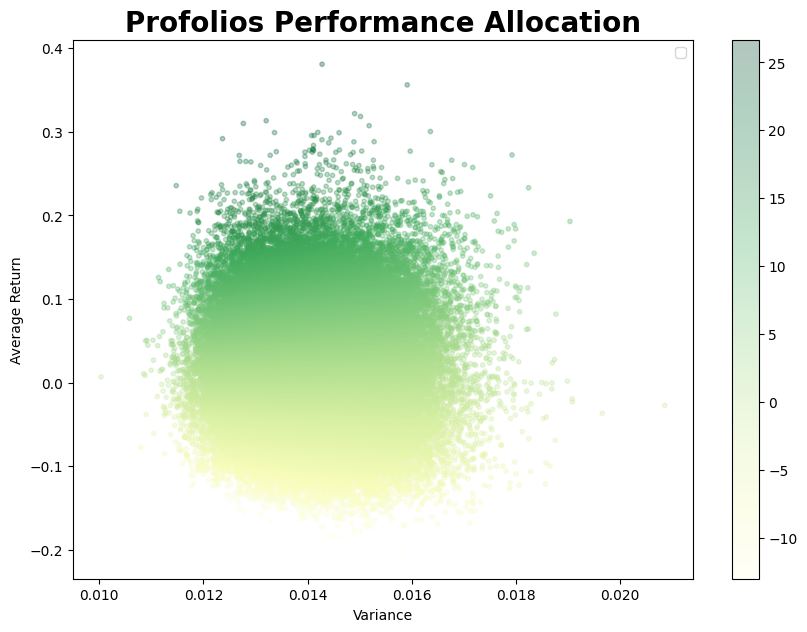

In [60]:
# 投資組合散佈圖

def profolios_allocation(mean_returns, cov_matrix, num_portfolios):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix)
      
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.title('Profolios Performance Allocation', fontsize=20,fontweight='bold',)
    plt.xlabel('Variance')
    plt.ylabel('Average Return')
    plt.legend(labelspacing=0.8)
    plt.show()
    
profolios_allocation(mean_returns, cov_matrix, num_portfolios)

In [61]:
# 建立風險函數
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

# 找出投資組合中最小風險
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0,1)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到相同投資組合報酬率下最小的風險
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1/num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

#找到效率前緣樣本
def efficient_profolios(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

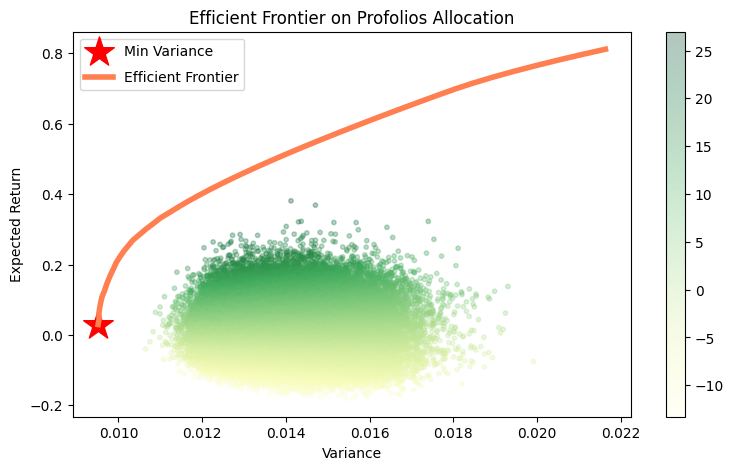

In [62]:
def display_efficient_frontier(mean_returns, cov_matrix, num_portfolios):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix)
     
    #點出所有投組報酬率及風險
    plt.figure(figsize=(9, 5))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGn', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    #找出最小風險投資組合及其報酬率
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_performance(min_vol['x'], mean_returns, cov_matrix)
    
    #點出最小風險之投資組合
    plt.scatter(sdp_min,rp_min,marker='*',color='red',s=500, label='Min Variance')

    #畫出所有投組樣本的效率前緣線    
    target = np.linspace(rp_min, mean_returns.max(), 50)
    efficient_portfolios = efficient_profolios(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], 
             target, linestyle='-', color='coral',linewidth=4, label='Efficient Frontier') 
    plt.title('Efficient Frontier on Profolios Allocation')
    plt.xlabel('Variance')
    plt.ylabel('Expected Return')
    plt.legend(labelspacing=0.9 ,loc ='upper left')
    plt.show()
    
display_efficient_frontier(mean_returns, cov_matrix, num_portfolios)

切線法

In [55]:
f = mean_returns.values

#建立不同的無風險利率(-0.1 ~ 0.1)
Rfs = np.linspace(-0.1, 0.1, 1000)

weights = []
for Rf in Rfs:
    Rf = np.full((f.shape[0], 1), Rf)
    f = f.reshape(10, 1)
    Rbar = f + Rf
    V = cov_matrix.values
    V_inv = np.linalg.inv(V)
    V_inv_Rbar = np.dot(V_inv, Rbar)

    # 計算 V^(-1) * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
    ones_vector = np.ones((10, 1))
    V_inv_ones = np.dot(V_inv, ones_vector)

    # 計算 Rf * (V^(-1) * 1)
    Rf_V_inv_ones = Rf * V_inv_ones
    Z = V_inv_Rbar - Rf_V_inv_ones

    # 計算 Z.T * 1，這裡的 1 是一個形狀為 (10, 1) 的 ndarray
    Z_transpose = Z.T
    Z_dot_ones = np.dot(Z_transpose, ones_vector)

    # 最後計算 X
    X = V_inv_Rbar - Rf_V_inv_ones / Z_dot_ones
    weights.append(X)


In [56]:
vars = []
fp = []
for weight in weights:
    var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
    vars.append(float(var))
    fp.append(float(np.dot(weight.T, f)))

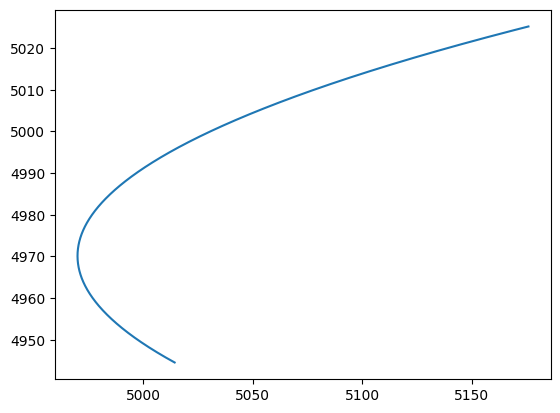

In [57]:
plt.plot(vars, fp)

切火腿法

In [67]:
f = mean_returns.values
f = f.reshape(10, 1)
#建立不同的無風險利率(-0.1 ~ 0.1)
Rfs = np.linspace(-0.1, 0.1, 1000)

weights = []
e = np.ones((10, 1))

for u in Rfs:
    V = cov_matrix.values
    V_inv = np.linalg.inv(V)
    A = e.T @ V_inv @ e
    B = e.T @ V_inv @ f
    C = f.T @ V_inv @ f
    D = (A @ C) - (B ** 2)
    _lambda = (C - u * B) / D
    _gamma = (A * u - B) / D
    h = _lambda * V_inv @ e + _gamma * V_inv @ f
    weights.append(h)

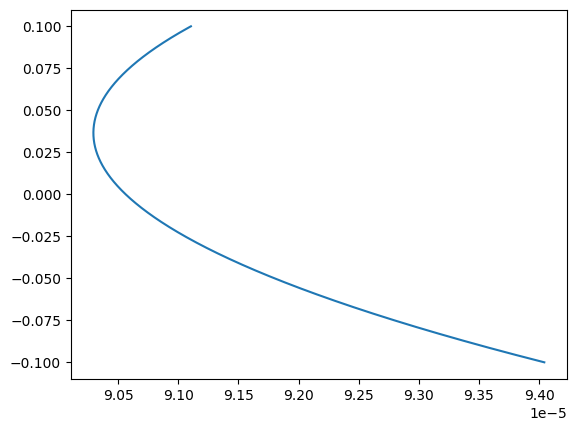

In [68]:
vars = []
fp = []
for weight in weights:
    var = np.dot(np.dot(weight.T, cov_matrix.values), weight)
    vars.append(float(var))
    fp.append(float(np.dot(weight.T, f)))

plt.plot(vars, fp)